Demo of visualizations of significance testing of dataset metrics between different LMMs

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), "..","unitxt","src"))
from unitxt.metric_paired_significance import PairedDifferenceTest

Assume we have a dataset of records (e.g., questions with ground truth answers, and predictions from several different models we want to compare).  For each record, we can calculate a metric value of the model accuracy (e.g., recall, precision, s-bert similarity).  Given a metric, we can compare model A vs B by testing whether, statistically, the metric value is very different (or higher/lower) on predictions from model A or B.  The metric values are *paired* (since the underlying record is the same, and the records are not repeated random samples) so the tests conducted assume paired observations.

Significance is defined in two ways:
- The p-value, which takes values in [0,1], and lower values indicate a higher significant difference
- The effect size, which overcomes the p-value tendency to overstate differences when the sample size is large

In [2]:
# read in the data
data = {mm: pd.read_csv('{}.csv'.format(mm)) for mm in ["recall", "precision", "sbert"]}
print(data['recall'].head())
# test combinations vs each other
tester_full = PairedDifferenceTest(nmodels=6, model_names=data["recall"].columns)

# perform test on each metric separately
test_results_twoside = [tester_full.signif_pair_diff(samples_list=[vv[cc].to_numpy() for cc in vv.columns], metric_name=kk) for kk, vv in data.items()]
# perform one-sided test (for example)
test_results_leftside = [tester_full.signif_pair_diff(samples_list=[vv[cc].to_numpy() for cc in vv.columns], metric_name=kk, alternative='less') for kk, vv in data.items()]

   bm25_llama13b  bm25_flant5xxl  bm25_granite13b  elser_llama13b  \
0       0.285714        0.285714         0.285714        0.142857   
1       0.142857        0.200000         0.228571        0.142857   
2       0.823529        0.823529         0.941176        0.882353   
3       0.413793        0.344828         0.517241        0.448276   
4       0.600000        1.000000         1.000000        0.700000   

   elser_flant5xxl  elser_granite13b  
0         0.142857          0.285714  
1         0.057143          0.114286  
2         0.882353          1.000000  
3         0.275862          0.310345  
4         0.500000          0.700000  
If 'alternative' is 'less', the samples are expected to be sorted in ascending order of ANTICIPATED (not OBSERVED) mean value
If 'alternative' is 'less', the samples are expected to be sorted in ascending order of ANTICIPATED (not OBSERVED) mean value
If 'alternative' is 'less', the samples are expected to be sorted in ascending order of ANTICIPATED

C:\Users\002060756\Anaconda3\envs\unitxt\lib\site-packages\statsmodels\stats\multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


Display the resulting objects containing the test results

In [8]:
print("two-sided (metrics are different)")
print(test_results_twoside[0])
print("left-sided (model A < model B)")
print(test_results_leftside[0])


two-sided (metrics are different)
DiffTest(model_names=Index(['bm25_llama13b', 'bm25_flant5xxl', 'bm25_granite13b', 'elser_llama13b',
       'elser_flant5xxl', 'elser_granite13b'],
      dtype='object'), metric_name='recall', pvalues=array([1.70241668e-04, 2.59362903e-03, 8.33198204e-02, 6.72046870e-01,
       6.32613519e-01, 6.72046870e-01, 8.91258720e-07, 2.44436304e-02,
       5.36609154e-02, 2.74431841e-05, 2.49927659e-01, 1.45790449e-01,
       3.26356913e-02, 1.34596010e-02, 9.61072598e-01]), alternative='two-sided', permute=False, corrected=True, pvalue_is_signif=array([ True,  True, False, False, False, False,  True,  True, False,
        True, False, False,  True,  True, False]), sample_means=array([0.5425482 , 0.43774584, 0.46083042, 0.58919122, 0.51526589,
       0.51394569]), effect_sizes=array([ 1.3141259 ,  1.10445829, -0.73697049,  0.27574912,  0.3570467 ,
       -0.29598334, -1.66616186, -0.89628892, -0.7977246 , -1.4441056 ,
       -0.56049908, -0.65455137,  0.85890206

A heatmap takes the tests between models across multiple metrics.  It shows which model pairs appear significantly different across the metrics.  More significant comparisons are displayed higher in the heatmap.

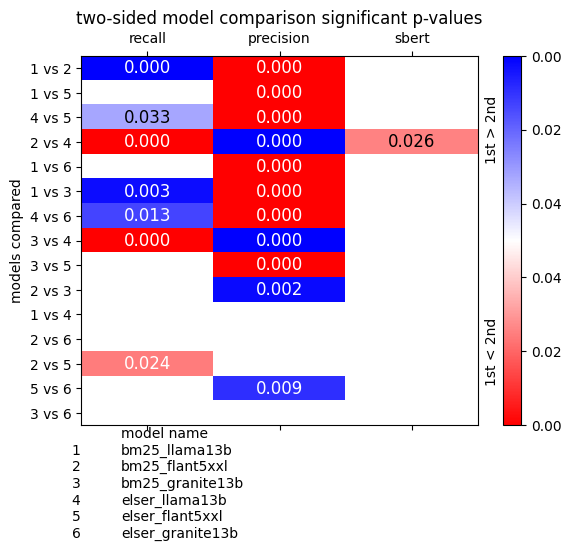

color optimized


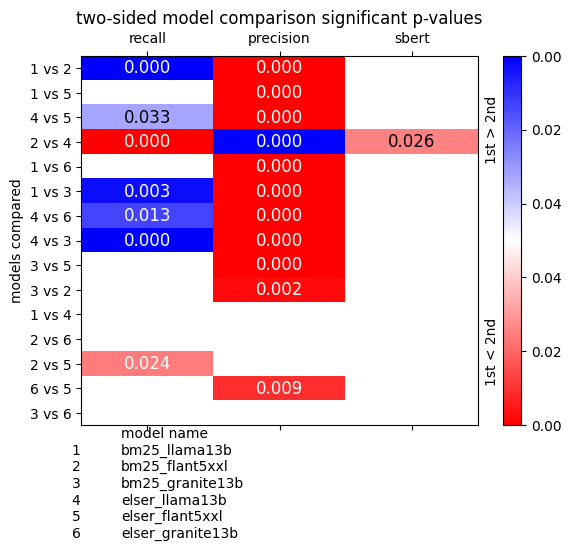

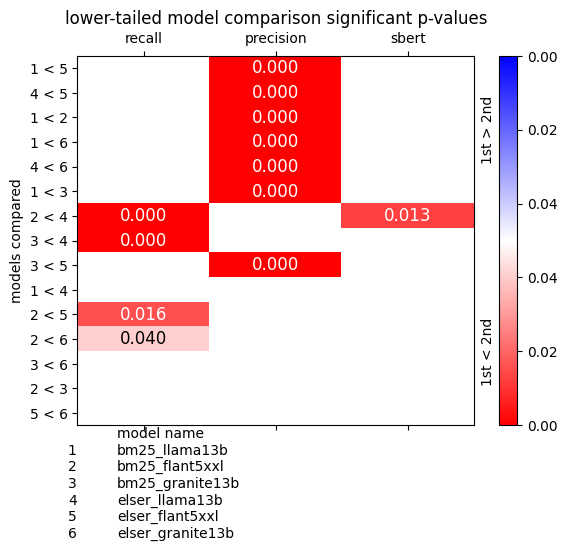

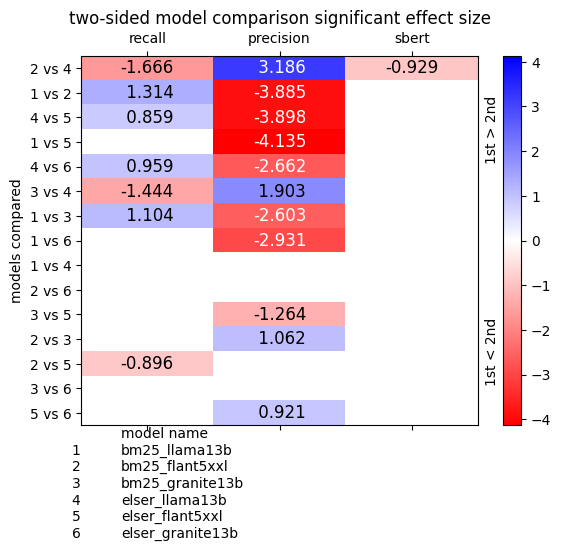

color optimized


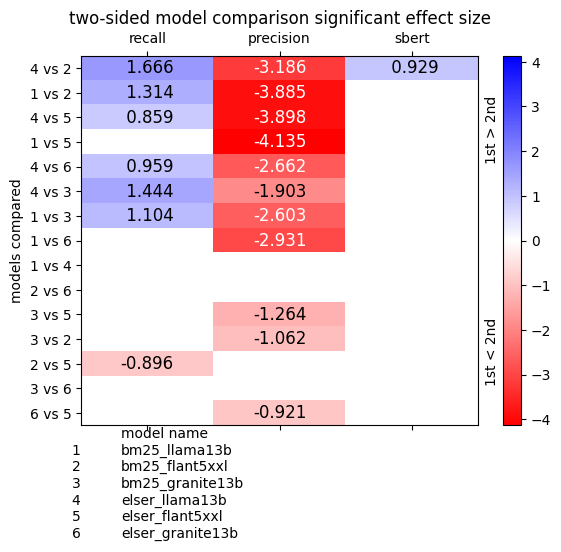

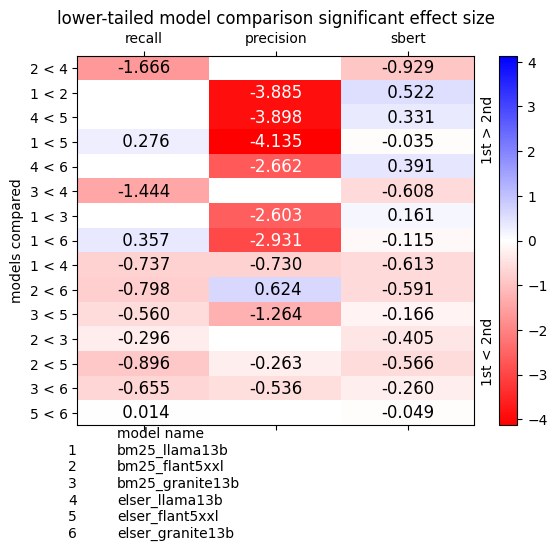

In [16]:
# heatmap comparing multiple metrics
tester_full.multiple_metrics_significance_heatmap(test_results_twoside, optimize_color=False)
print("color optimized")
tester_full.multiple_metrics_significance_heatmap(test_results_twoside)

tester_full.multiple_metrics_significance_heatmap(test_results_leftside)
# use Cohen's d effect size instead
tester_full.multiple_metrics_significance_heatmap(test_results_twoside, use_pvalues=False, optimize_color=False)
print("color optimized")
tester_full.multiple_metrics_significance_heatmap(test_results_twoside, use_pvalues=False)

tester_full.multiple_metrics_significance_heatmap(test_results_leftside, use_pvalues=False)

Plot a connected graph, were nodes represent models.
The vertical orientation of nodes corresponds to the mean value of the metric.
Nodes that are significantly different are connected by an edge; thicker edges mean a less significant difference.  For example, if all comparisons are significant, we will see all nodes unconnected, without edges.  The graph allows us to visualize groupings of similarly-performing models.

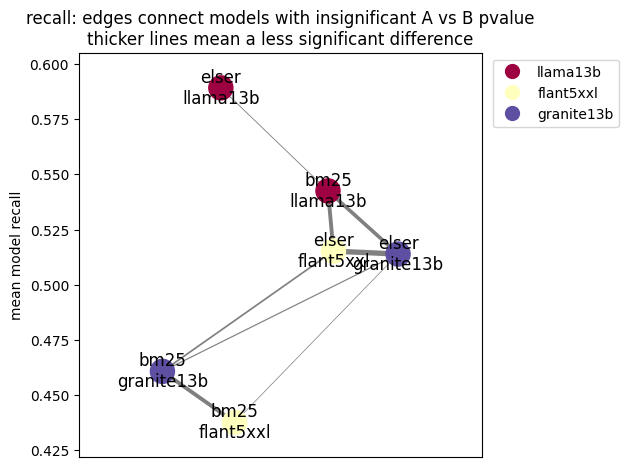

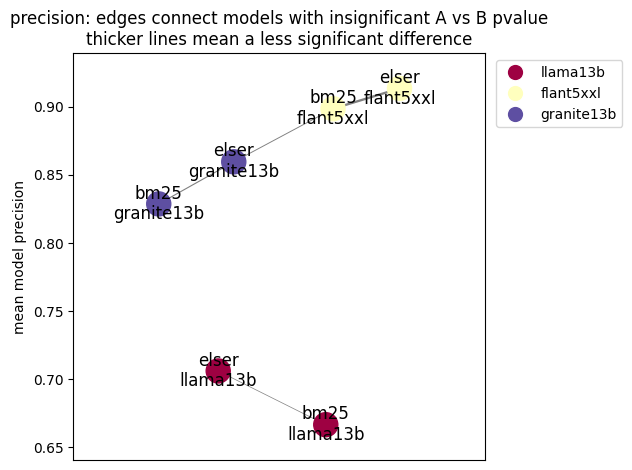

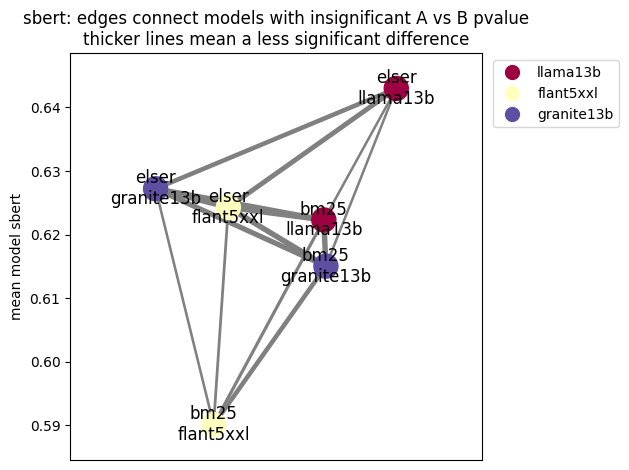

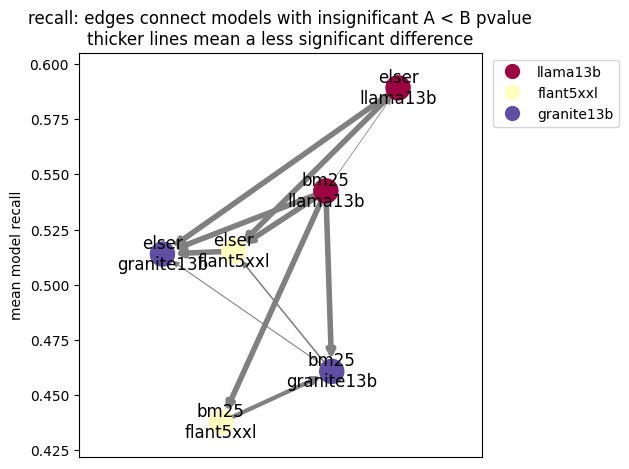

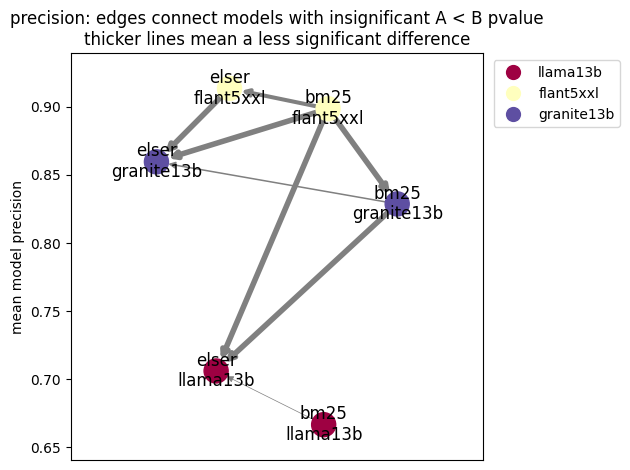

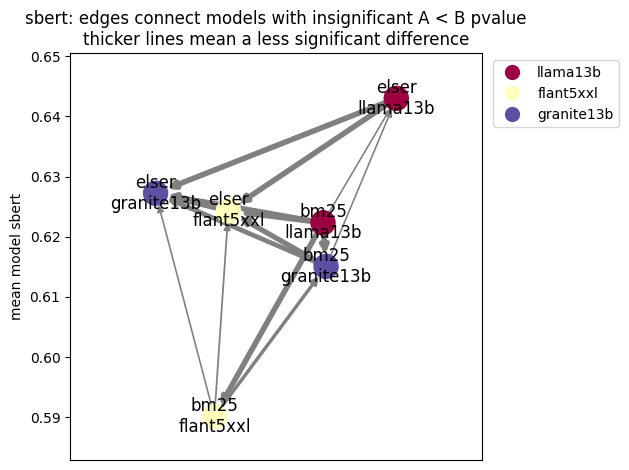

In [14]:
# use retrieval and model to code the node drawings with color
# graph shows NOT SIGNIFICANT pairwise comparisons connected by an edge

node_color_levels = [mn.split('_')[1] for mn in tester_full.model_names]

for res in test_results_twoside + test_results_leftside:
    tester_full.metric_significant_pairs_graph(test_res=res, model_name_split_char="_", node_color_levels=node_color_levels, weight_edges=True)

A lineplot shows p-values by connecting the compared models with a line segment.  Initially the models are arranged along the y-axis according to the sample mean of the metric; each model is assigned a given color.  The horizontal location of the line segment is at the p-value, with more significant comparisons placed to the left.  Using this method, it is not as easy to visualize the significant comparisons because the segments tend to be overplotted.  We recommend the connected graph above.

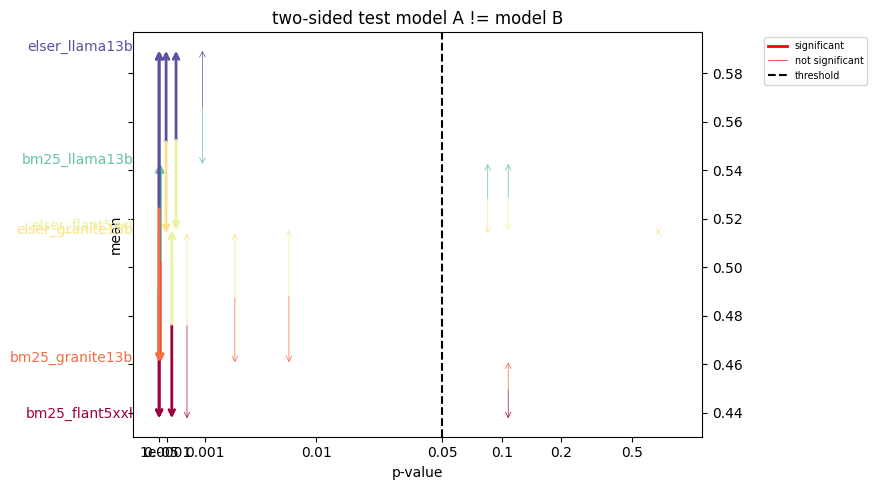

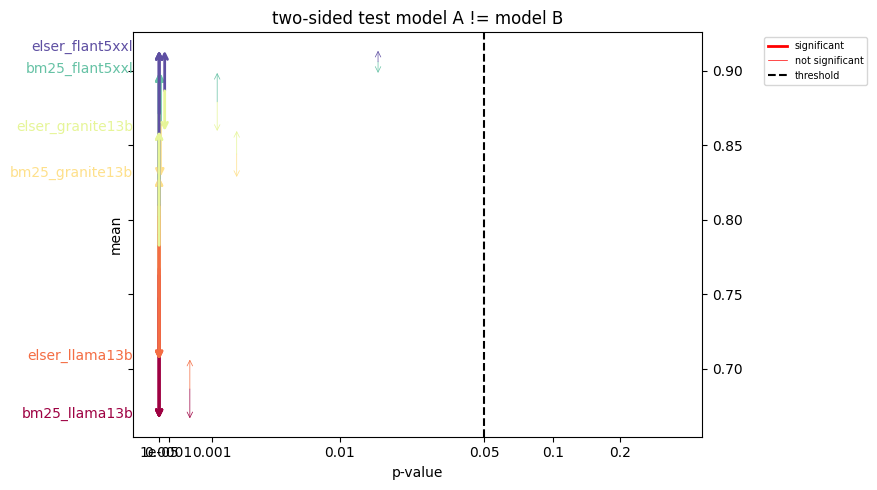

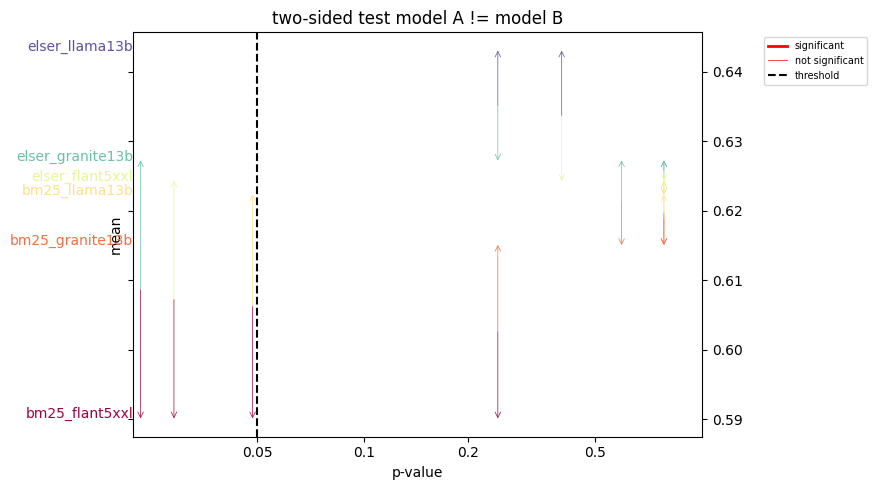

In [15]:
# lineplot shows p-values of pairwise comparisons by significance
# significant pairs are shown toward the left side of the plot
for vv in test_results_twoside:
    tester_full.pvalue_lineplot(vv)